[View in Colaboratory](https://colab.research.google.com/github/Iamnotabear/Deep_dream/blob/master/deep_dream_keras.ipynb)

In [0]:
#importing framewroks and libraries
import keras
from keras.applications import inception_v3
from keras import backend as K
import scipy
from keras.preprocessing import image
from matplotlib import pyplot as plt
import numpy as np

In [0]:
#stopping training of pre trained model
K.set_learning_phase(0)

#loading model inception
model = inception_v3.InceptionV3( weights='imagenet', include_top=False )

In [159]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [0]:
#downloading image in colab
import os
dir = '/tmp/dd'
if not os.path.exists(dir):
  os.makedirs(dir)
  
!wget --quiet -P /tmp/dd https://static.boredpanda.com/blog/wp-content/uuuploads/landscape-photography/landscape-photography-13.jpg
  
image_path = '/tmp/dd/landscape-photography-13.jpg'

In [0]:
def preprocess_image(image_path):
    img = image.load_img(image_path) #loading image
    img = image.img_to_array(img) #convert to array
    img = np.expand_dims(img, axis=0) # add batch dimensions
    img = inception_v3.preprocess_input(img) # preprocessing
    return img
  
def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3)) #reshaping to ( h,w,c )
    
    #deprocess
    x /= 2. 
    x += 0.5
    x *= 255.
    
    #clipping value out if range ( 0,255 ) ie out RGB value range
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def resize_img(img, size):
  
  img = np.copy(img)
  
  #ratios to multiply to image dimensions to resize
  factors = (1,
             float(size[0]/img.shape[1]),
             float(size[1]/img.shape[2]),
             1                
            )
  #applying ratios using scipy
  return  scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

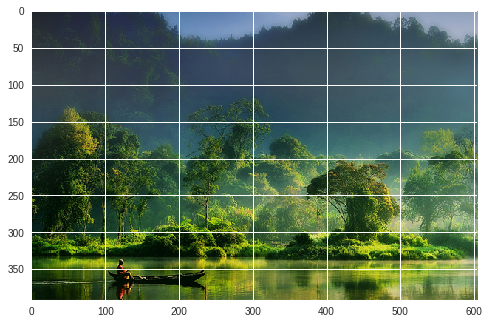

In [88]:
#checking working of preprocess and deprocess functions
img=preprocess_image(image_path)
img=deprocess_image(img)
plt.imshow(img)

In [0]:
#conntribution of each layers activation coefficient
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [0]:
#initial total weighted loss of the activations of the selected layers 
def loss_init():
    loss = 0
    layer_dict = dict([layer.name, layer]for layer in model.layers) # making dictionary of layers and their instances
    for layer_name in  layer_contributions:
        
        coeff = layer_contributions[layer_name]  # getting coefficients of the given layer
        activations = layer_dict[layer_name].output # getting layer instance activations
        
        #normalizing and clipping borders
        
        scale = K.prod(K.cast(K.shape(activations), 'float32')) # scale used for normalizing 
        
        # not including first two pixel border of the width and height
        loss += coeff * K.sum(K.square(activations[: ,2:-2, 2:-2, :]))/scale # summation and normaliziation 
     
    return loss

In [0]:
loss = loss_init() #getting initial loss
dream = model.input #dream image to hold input

gradients = K.gradients(loss, dream)[0] # gradient of loss wrt to dream image
gradients /= K.maximum(K.mean(K.abs(gradients)), 1e-7) # normalizing gradients

output = [loss, gradients] # making list of loss and grads
loss_and_grads = K.function([dream], output) #keras functions for input and output

In [0]:
#getting loss and gradients wrt dream image
def fetch_loss_and_grad(img):
    
    outputs = loss_and_grads([img])
    
    return outputs[0], outputs[1]
  
#applying gradients on dream image via gradient ascent  
def gradient_ascent(img, iter, step_alpha, max_loss=None):

    for i in range(iter):
        loss, grads = fetch_loss_and_grad(img) #loading loss and grading with current state of dream image
        if max_loss is not None and loss > max_loss: #loss should not be greater than a fixed max_loss or it will go on maximizing
          break
        print('...Loss value at', i, ':', loss)
        img += step_alpha * grads #adding gradients to dream image by multiplying with step_alpha similarly to gradient descent's alpha
    
    return img

In [0]:
def dream_maker( image_path=image_path , step=0.01, octave = 3, octave_scale = 1.4, iter=200, max_loss = 10):
  
    
    img = preprocess_image(image_path) #preprocess image according to inception
    
    original_shape = img.shape[1:3] #extracting ( h,w )
    #list of tuples
    succesive_shapes = [original_shape]
    
    for i in range(1,octave):
      
        tuple_of_shapes = tuple([ int( shape/ (octave_scale ** i)) for shape in original_shape ]) #making reduced tuple of ( h,w )
        succesive_shapes.append( tuple_of_shapes )
    succesive_shapes = succesive_shapes[::-1] #reversing small to large
    
    original_img = np.copy(img) #copy image
    smallest_original_image = resize_img( original_img, succesive_shapes[0] ) #resizing original image to smallest octave
    
    for shape in succesive_shapes:
      
      print('Processing image shape', shape)
      img  = resize_img( img  , shape) #resizing image to shape 
      
      img = gradient_ascent( img, 200, 0.01, 10 ) #applying gradient ascent on current current size of the image
      
      upscaled_smallest_original = resize_img( smallest_original_image, shape ) #getting original image of the current size
      downsized_original_image = resize_img( original_img, shape ) # reducing size of high resolution to current size
      
      details = downsized_original_image - upscaled_smallest_original # details we get after subtracting and these will be added to pixelated image
      
      img += details # adding lost details due to resizing
      
         
    return deprocess_image(img)


In [161]:
img = dream_maker()

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (200, 308)
gradient_ascent
loss 1.1212442
...Loss value at 0 : 1.1212442
loss 1.5726123
...Loss value at 1 : 1.5726123
loss 2.1456125
...Loss value at 2 : 2.1456125
loss 2.837785
...Loss value at 3 : 2.837785
loss 3.4850416
...Loss value at 4 : 3.4850416
loss 4.150478
...Loss value at 5 : 4.150478
loss 4.76964
...Loss value at 6 : 4.76964
loss 5.397955
...Loss value at 7 : 5.397955
loss 5.9593954
...Loss value at 8 : 5.9593954
loss 6.540545
...Loss value at 9 : 6.540545
loss 7.058865
...Loss value at 10 : 7.058865
loss 7.5878725
...Loss value at 11 : 7.5878725
loss 8.193394
...Loss value at 12 : 8.193394
loss 8.645876
...Loss value at 13 : 8.645876
loss 9.18048
...Loss value at 14 : 9.18048
loss 9.610954
...Loss value at 15 : 9.610954
loss 10.128538
Processing image shape (280, 432)
gradient_ascent
loss 2.7887802
...Loss value at 0 : 2.7887802
loss 4.1457133
...Loss value at 1 : 4.1457133
loss 5.243283
...Loss value at 2 : 5.243283
loss 6.2567086
...Loss value at

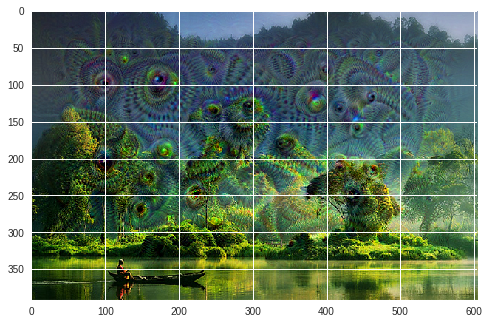

In [162]:
plt.imshow( img )